In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Final_dataset.csv", on_bad_lines='skip', engine='python')

In [ ]:
data=df[['statement','status']]
display(data.head(20))

,statement,status
0,"['oh', 'my', 'gosh']",Anxiety
1,"['trouble', 'sleep', 'confused', 'mind', 'rest...",Anxiety
2,"['all', 'wrong', 'back', 'off', 'dear', 'forwa...",Anxiety
3,"['I', 've', 'shift', 'my', 'focus', 'to', 'som...",Anxiety
4,"['I', 'm', 'restless', 'and', 'restless', 'its...",Anxiety
5,"['every', 'break', 'you', 'must', 'be', 'nervo...",Anxiety
6,"['I', 'feel', 'scared', 'anxious', 'what', 'ca...",Anxiety
7,"['have', 'you', 'ever', 'feel', 'nervous', 'bu...",Anxiety
8,"['I', 'have', 'not', 'sleep', 'well', 'for', '...",Anxiety
9,"['I', 'm', 'really', 'worried', 'I', 'want', '...",Anxiety


In [ ]:
data.status.value_counts()

,count
status,
Normal,16020
Depression,15086
Suicidal,10641
Anxiety,3613
Bipolar,2501
Stress,2293
Personality disorder,895


In [ ]:
from sklearn.utils import resample

df_sample = df.sample(n=min(20000, len(df)), random_state=42)

if 0 in df_sample['status'].values:
    majority_size = len(df_sample[df_sample['status']==0])
else:
    class_counts = df_sample['status'].value_counts()
    majority_size = class_counts.iloc[0]
    print(f"Status 0 not found in sample. Using majority class size: {majority_size}")

def resampling(df_subset, target_size):
    """Resample a dataframe subset to target size"""
    if len(df_subset) == 0:
        return df_subset
    if len(df_subset) >= target_size:
        return df_subset.sample(n=target_size, random_state=42, replace=False)
    else:
        return resample(df_subset, replace=True, n_samples=target_size, random_state=42)

unique_statuses = sorted(df_sample['status'].unique())
print(f"\nUnique status values in sample: {unique_statuses}")

resampled_dfs = []
for status_val in unique_statuses:
    df_class = df_sample[df_sample['status'] == status_val]
    resampled_df = resampling(df_class, majority_size)
    print(f"Status {status_val}: Original {len(df_class)} → Resampled {len(resampled_df)}")
    resampled_dfs.append(resampled_df)

df_new = pd.concat(resampled_dfs, axis=0).reset_index(drop=True)

print("\nAfter resampling class distribution:")
print(df_new['status'].value_counts())
print(f"\nTotal samples: {len(df_new)}")

data = df_new[['statement','status']]

Status 0 not found in sample. Using majority class size: 6353

Unique status values in sample: ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']
Status Anxiety: Original 1389 → Resampled 6353
Status Bipolar: Original 1019 → Resampled 6353
Status Depression: Original 5912 → Resampled 6353
Status Normal: Original 6353 → Resampled 6353
Status Personality disorder: Original 340 → Resampled 6353
Status Stress: Original 886 → Resampled 6353
Status Suicidal: Original 4101 → Resampled 6353

After resampling class distribution:
status
Anxiety                 6353
Bipolar                 6353
Depression              6353
Normal                  6353
Personality disorder    6353
Stress                  6353
Suicidal                6353
Name: count, dtype: int64

Total samples: 44471


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['status_encoded'] = label_encoder.fit_transform(data['status'])

In [ ]:
print("\nLabel encoding mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Label encoding mapping:
Anxiety: 0
Bipolar: 1
Depression: 2
Normal: 3
Personality disorder: 4
Stress: 5
Suicidal: 6


In [ ]:
X = data['statement']
y = data['status_encoded']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 35576
Test set size: 8895


In [ ]:
!pip install gensim

from gensim.models import FastText
import numpy as np


sentences = [sentence.split() for sentence in X_train]

ft_model = FastText(sentences, vector_size=100, window=5, min_count=5, workers=4, sg=1)

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [ft_model.wv[word] for word in words]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_vec = np.array([vectorize(sentence) for sentence in X_train])
X_test_vec = np.array([vectorize(sentence) for sentence in X_test])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 34.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
batch_size = 32

train_dataset = SentimentDataset(X_train_vec, y_train)
test_dataset  = SentimentDataset(X_test_vec, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch.nn as nn

In [ ]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, (hn, _) = self.lstm(x)
        hn = torch.cat([hn[-2], hn[-1]], dim=1)
        out = self.fc(hn)
        return out

In [ ]:
input_size = X_train_vec.shape[1]
hidden_size = 128
num_classes = len(label_encoder.classes_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMClassifier(input_size, hidden_size, num_classes).to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 100

train_losses, train_accs = [], []
test_losses, test_accs = [], []


In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    test_running_loss, test_correct, test_total = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            test_running_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == y_batch).sum().item()
            test_total += y_batch.size(0)

    test_loss = test_running_loss / test_total
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1/100 | Train Loss: 1.2287, Train Acc: 0.5580 | Test Loss: 1.0211, Test Acc: 0.6405
Epoch 2/100 | Train Loss: 0.9858, Train Acc: 0.6466 | Test Loss: 0.9557, Test Acc: 0.6633
Epoch 3/100 | Train Loss: 0.9415, Train Acc: 0.6614 | Test Loss: 0.9203, Test Acc: 0.6771
Epoch 4/100 | Train Loss: 0.9163, Train Acc: 0.6669 | Test Loss: 0.9087, Test Acc: 0.6699
Epoch 5/100 | Train Loss: 0.8955, Train Acc: 0.6753 | Test Loss: 0.8900, Test Acc: 0.6788
Epoch 6/100 | Train Loss: 0.8815, Train Acc: 0.6798 | Test Loss: 0.8875, Test Acc: 0.6816
Epoch 7/100 | Train Loss: 0.8673, Train Acc: 0.6815 | Test Loss: 0.9083, Test Acc: 0.6626
Epoch 8/100 | Train Loss: 0.8543, Train Acc: 0.6858 | Test Loss: 0.8751, Test Acc: 0.6830
Epoch 9/100 | Train Loss: 0.8432, Train Acc: 0.6911 | Test Loss: 0.8463, Test Acc: 0.6906
Epoch 10/100 | Train Loss: 0.8292, Train Acc: 0.6942 | Test Loss: 0.8272, Test Acc: 0.6960
Epoch 11/100 | Train Loss: 0.8183, Train Acc: 0.6986 | Test Loss: 0.8201, Test Acc: 0.7049
Epoch 12

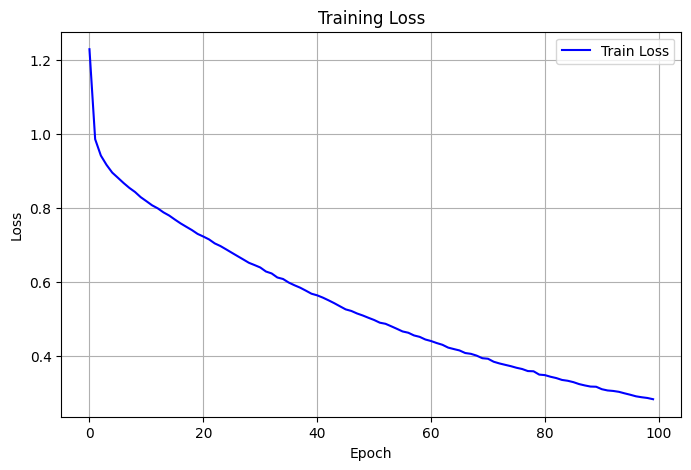

In [ ]:
import matplotlib.pyplot as plt

# Training Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

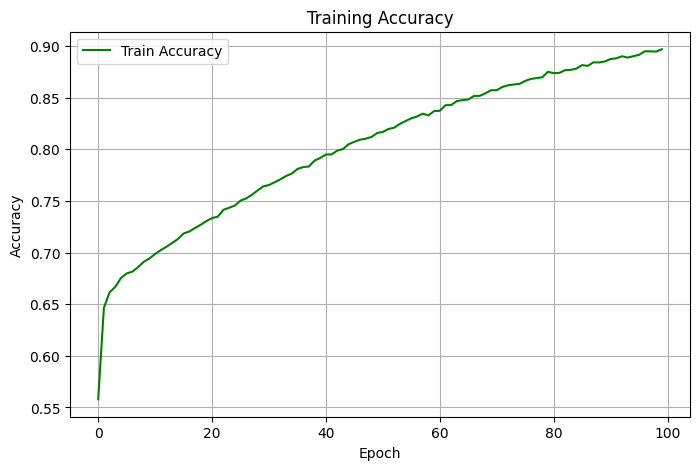

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_accs, label='Train Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.grid(True)
plt.show()

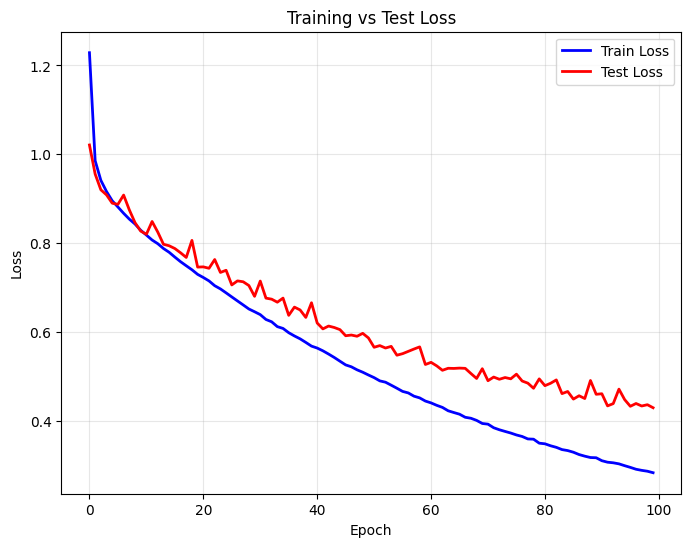

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(test_losses, label='Test Loss', color='red', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True, alpha=0.3)

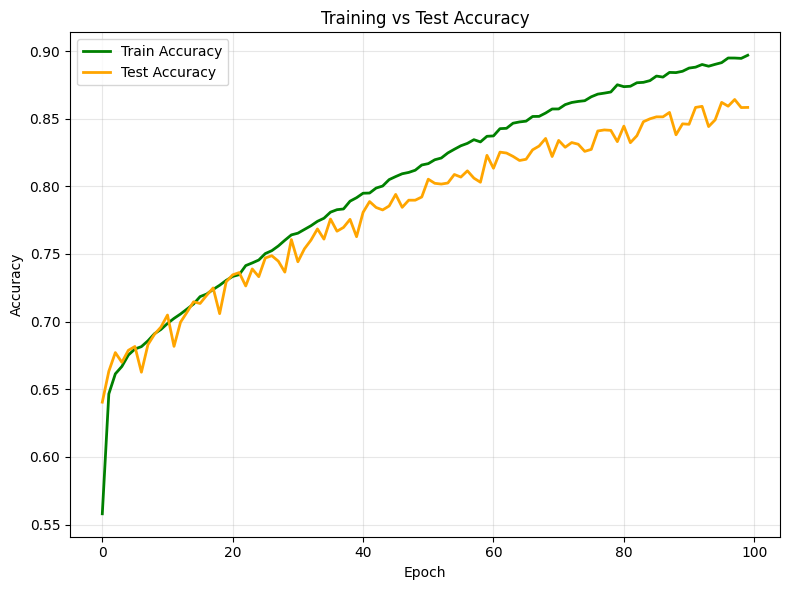

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_accs, label='Train Accuracy', color='green', linewidth=2)
plt.plot(test_accs, label='Test Accuracy', color='orange', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())


print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

Classification Report:

                      precision    recall  f1-score   support

             Anxiety       0.94      0.93      0.94      1270
             Bipolar       0.93      0.91      0.92      1270
          Depression       0.66      0.64      0.65      1271
              Normal       0.90      0.88      0.89      1271
Personality disorder       0.97      1.00      0.98      1271
              Stress       0.94      0.84      0.89      1271
            Suicidal       0.69      0.80      0.74      1271

            accuracy                           0.86      8895
           macro avg       0.86      0.86      0.86      8895
        weighted avg       0.86      0.86      0.86      8895



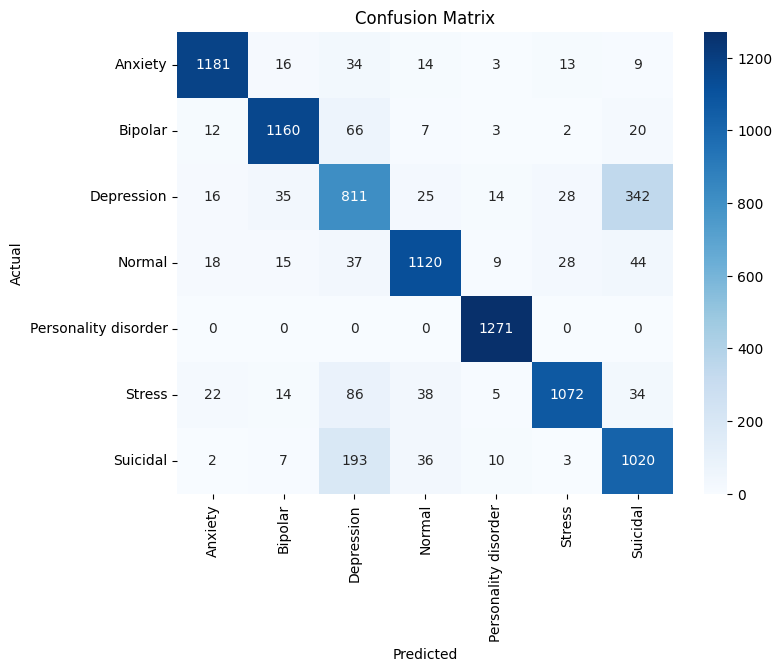

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()